In [15]:
import pandas as pd
import warnings
from pandas import DataFrame
from scipy.signal import filtfilt, butter
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates as mdates
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from parser_utils import folder_selection_utils
from scipy.stats import linregress
import os
import math
import parser_utils.parser_logger
import logging
import json
from parser_utils import folder_selection_utils
from torque_log_analysis import resample_data,drop_rows_from_df,lpf_df

warnings.simplefilter(action='ignore',category=pd.errors.PerformanceWarning)
# steps


- first, select folder for logs of car 1
- select folder for logs of car 2
- load logs, join
- set rpm to index
- join them all
- keep rows where torque is max for given rpm

In [16]:
car1folder = folder_selection_utils.select_folder_and_get_path()
car2folder = folder_selection_utils.select_folder_and_get_path()
folders = [car1folder,car2folder]
print(f"Car 1 : '{car1folder}'\nCar 2: '{car2folder}'")

Car 1 : 'C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data'
Car 2: 'C:/Users/Matthew Samson/Documents/formula/228hv/parsed-data'


In [20]:
car_log_cols_to_keep = [
    "Time", "D1_Commanded_Torque", "D2_Torque_Feedback", "D2_Motor_Speed"]

df_list = []
for folder in folders:
    folder_dfs = []
    for filename in os.listdir(folder):
        # print(f"Folder: {folder}")
        if filename.endswith('.csv') or filename.endswith('.CSV'):
            print(f"Filename: {filename}")
            file_path = os.path.join(folder, filename)
            try:
                df = pd.read_csv(file_path)
                if df["D2_Motor_Speed"].max() < 2000:
                    print(f"Skipping {file_path} because motor speed less than 2000 max")
                    continue

                df = df[car_log_cols_to_keep]
                for col in list(df):
                    print(f"Old df col:{col} Max: {df[col].max()}")
                df = resample_data(df, "Time")
                df = drop_rows_from_df(df,"D1_Commanded_Torque",1,400)


                df = drop_rows_from_df(df, "D2_Motor_Speed", 10, 7000)
                df = lpf_df(df,2)
                df['filtD2_Motor_Speed'] = df['filtD2_Motor_Speed']/10
                df['filtD2_Motor_Speed'] = df['filtD2_Motor_Speed'].round(decimals=0)
                df['filtD2_Motor_Speed'] = df['filtD2_Motor_Speed']*10
                idx = df.groupby('filtD2_Motor_Speed')['filtD2_Torque_Feedback'].idxmax()
                filtdf = df.loc[idx]
                for col in list(filtdf):
                    print(f"New df col:{col} Max: {filtdf[col].max()}")
                # df.set_index('filtD2_Motor_Speed',inplace=True)
                folder_dfs.append(filtdf)
                print("mader it here")
            except:
                print(f"Error with {file_path}")
    print(folder_dfs)
    folder_df = pd.concat(folder_dfs)
    df_list.append(folder_df)
car1df = df_list[0]
car2df = df_list[1]
car3df = df_list[1]



Filename: parseddata0000.CSV
Old df col:Time Max: 1682526270573
Old df col:D1_Commanded_Torque Max: 196.7
Old df col:D2_Torque_Feedback Max: 181.6
Old df col:D2_Motor_Speed Max: 4706.0
2Hz
New df col:D1_Commanded_Torque Max: 195.56153846153845
New df col:D2_Torque_Feedback Max: 179.36923076923077
New df col:D2_Motor_Speed Max: 4704.935483870968
New df col:filtD1_Commanded_Torque Max: 176.435937840305
New df col:filtD2_Torque_Feedback Max: 156.61453819433186
New df col:filtD2_Motor_Speed Max: 4860.0
mader it here
Filename: parseddata0001.CSV
Old df col:Time Max: 1682532192083
Old df col:D1_Commanded_Torque Max: 1.6
Old df col:D2_Torque_Feedback Max: 256.0
Old df col:D2_Motor_Speed Max: 2304.0
2Hz
Error with C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0001.CSV
Filename: parseddata0002.CSV
Skipping C:/Users/Matthew Samson/Documents/formula/4-26-2023_dyno_and_regen/parsed-data\parseddata0002.CSV because motor speed less than 2000 max
Filename: p

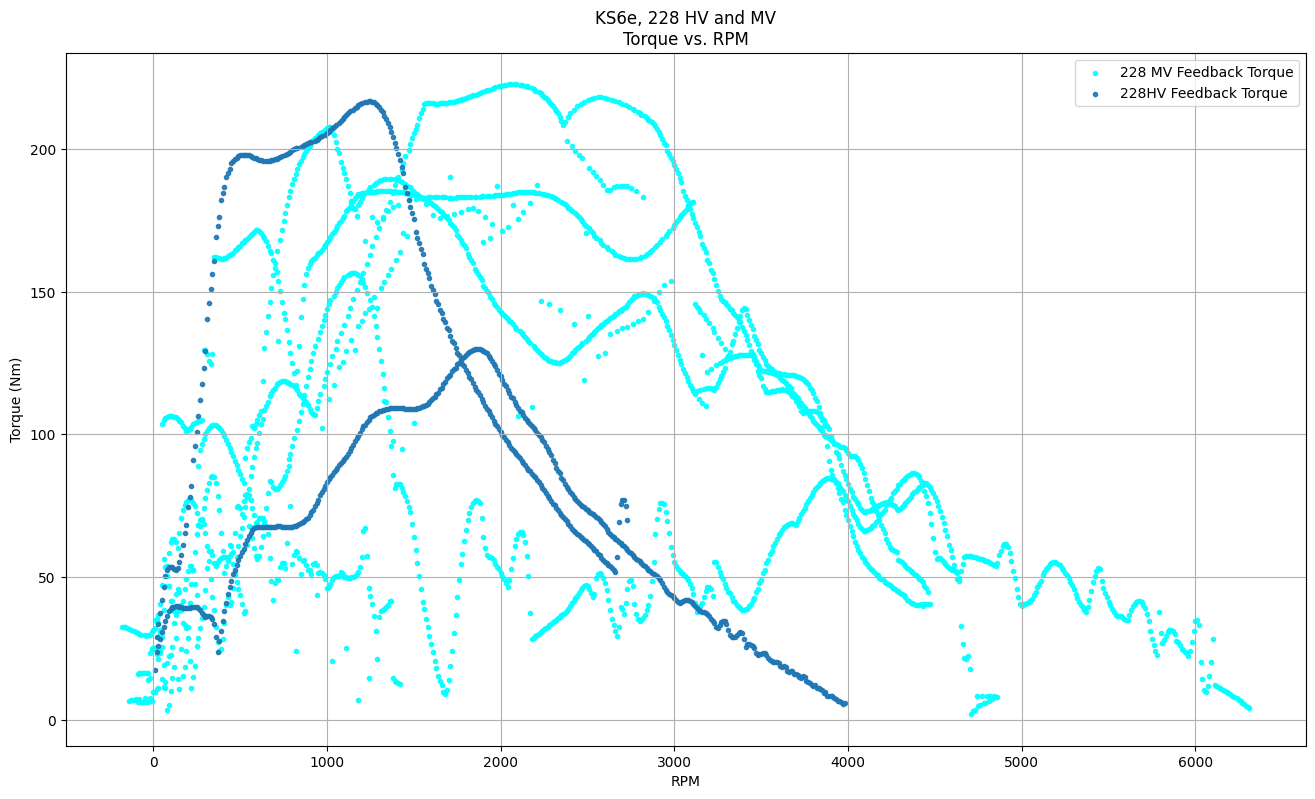

In [22]:
fig, ax = plt.subplots(figsize=(16,9))
# ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD1_Commanded_Torque'],
#                 marker='.', label="Car 1Command Torque", c='blue', alpha=0.9)
ax.scatter(car1df['filtD2_Motor_Speed'], car1df['filtD2_Torque_Feedback'],
                marker='.', label="228 MV Feedback Torque", c='aqua', alpha=0.9)
# ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD1_Commanded_Torque'],
#                 marker='.', label="Car 2Command Torque", alpha=0.9)
ax.scatter(car2df['filtD2_Motor_Speed'], car2df['filtD2_Torque_Feedback'],
                marker='.', label="228HV Feedback Torque", alpha=0.9)
plt.title("KS6e, 228 HV and MV\nTorque vs. RPM")
ax.grid(visible=True)
plt.xlabel("RPM")
plt.ylabel("Torque (Nm)")
plt.legend()